## Name:- Raghav Virmani
## Roll Number:- 101803657
## Batch:- COE1

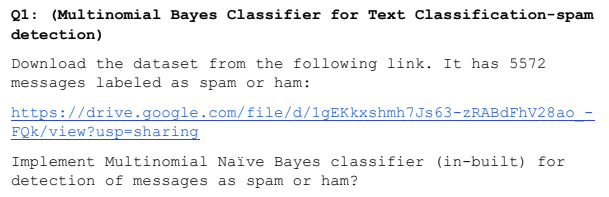

In [ ]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

In [ ]:
#convert to csv and read with adding column names
df=pd.read_csv("message.csv",sep='\t',names=['label','text'])

In [ ]:
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
#check null values
df.isna().sum()

label    0
text     0
dtype: int64

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#stopword loading for text cleaning
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
#text cleaning and lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text) 

In [ ]:
df.text = df.text.apply(lemmatize_words)


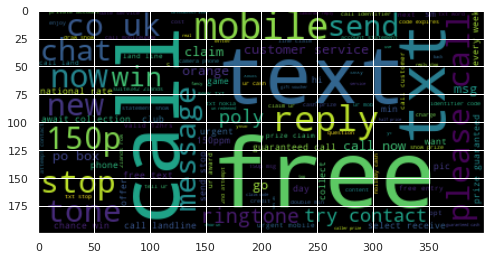

In [ ]:
#SPAM WordCloud
plt.figure(figsize = (8,8)) 
wc = WordCloud(width = 400 , height = 200 , max_words = 3000).generate(" ".join(df[df.label == 'spam'].text))
plt.imshow(wc , interpolation = 'bilinear')

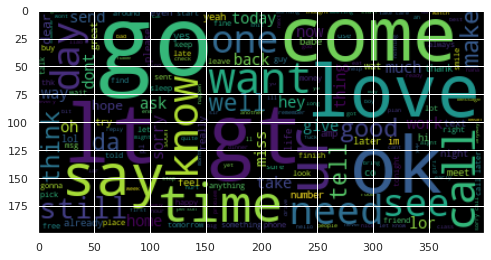

In [ ]:
#HAM WordCloud
plt.figure(figsize = (8,8)) 
wc = WordCloud(width = 400 , height = 200 , max_words = 3000).generate(" ".join(df[df.label == 'ham'].text))
plt.imshow(wc , interpolation = 'bilinear')

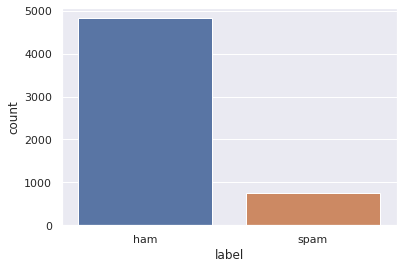

In [ ]:
#class distribution
sns.set(style="darkgrid")
sns.countplot(x = "label" , data = df)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
X=df['text']
y=le.fit_transform(df['label'])

In [ ]:
#unbalenced dataset, hence we have to stratify
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
mnb=MultinomialNB()
roc=[]
acc=[]
from sklearn.metrics import *
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    tv_train_reviews=tv.fit_transform(x_train_fold)
    tv_test_reviews=tv.transform(x_test_fold)
    mnb.fit(tv_train_reviews,y_train_fold)
    roc.append(roc_auc_score(mnb.predict(tv_test_reviews), y_test_fold))
    acc.append(accuracy_score(mnb.predict(tv_test_reviews), y_test_fold))

print("Mean roc auc for 10 folds : {}".format(np.mean(roc)))
print("Mean acc for 10 folds : {}".format(np.mean(acc)))

Mean roc auc for 10 folds : 0.936578541468881
Mean acc for 10 folds : 0.8741912961783236


In [ ]:
#classification report
mnb_report = classification_report(y_test_fold,mnb.predict(tv_test_reviews),target_names = ['0','1'])
print(mnb_report)


              precision    recall  f1-score   support

           0       0.87      1.00      0.93       482
           1       1.00      0.01      0.03        75

    accuracy                           0.87       557
   macro avg       0.93      0.51      0.48       557
weighted avg       0.88      0.87      0.81       557



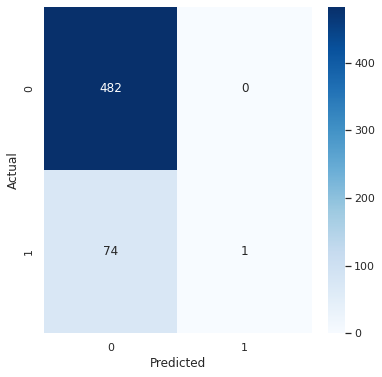

In [ ]:
#confusion matrix
cm_tv = confusion_matrix(y_test_fold,mnb.predict(tv_test_reviews))
cm_cv = pd.DataFrame(cm_tv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'
plt.figure(figsize = (6,6))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

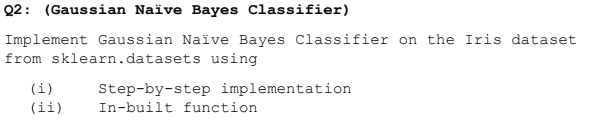

In [ ]:
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvn

In [ ]:
#from scratch
class GaussianNaiveBayes:
    
    # fit methods trains the data
    def fit(self,X,y,spar=10e-3): # here self is the variable which refers to current object of class 
        number_of_sample,number_of_features = X.shape # returns shape of X which is NxD dimensional
        # categories contains classes in Y uniquely due to Set
        self.categories=np.unique(y)
        
        # number_of_classes is the local variable
        number_of_classes=len(self.categories)
        
        # Initialising mean, var and priors
        self.gaussian_mean=np.zeros((number_of_classes,number_of_features),dtype=np.float64)
        self.gaussian_var=np.zeros((number_of_classes,number_of_features),dtype=np.float64)
        self.log_prior=np.zeros((number_of_classes),dtype=np.float64)
        
        # Calculating mean,var,prior based on categories in Y
        for classes in self.categories:
            X_classes=X[classes==y] # grouping into X_classes array according to category in y
            self.gaussian_mean[classes,:]=X_classes.mean(axis=0) # mean with each row of sample belonging particular column(features)
            self.gaussian_var[classes,:]=X_classes.var(axis=0)+spar
            self.log_prior[classes]=np.log(X_classes.shape[0]/float(number_of_sample)) #number of sample in a class/ total samples
            # i have logged prior because in posterior we will be calculation log_pdf in predict
            
        
        
        
    
    
    # predict method make prediction
    def predict(self,X):
        # posterior probablity dimension (number of sample,number of categories)
        posteriorS=np.zeros((X.shape[0],len(self.categories)))
        for classes in self.categories: # calculating posterior with log of class_conditional probablity + log prior 
            posteriorS[:,classes]=mvn.logpdf(X,
                                             mean=self.gaussian_mean[classes,:],
                                             cov=self.gaussian_var[classes,:]) + self.log_prior[classes]
        return np.argmax(posteriorS,axis=1)
        
    def accuracy(self,y_true,predicted):
        return np.mean(y_true==predicted)

In [ ]:
from sklearn.datasets import load_iris
X,y=load_iris(return_X_y=True)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [ ]:
nb=GaussianNaiveBayes()
nb.fit(X_train,y_train)

In [ ]:
# predicting on test-set
pr=nb.predict(X_test)

In [ ]:
# Checking Accuracy
nb.accuracy(y_test,pr)

0.9736842105263158

In [ ]:
#using sklearn
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb.fit(X_train,y_train)
accuracy_score(gnb.predict(X_test),y_test)

0.9736842105263158

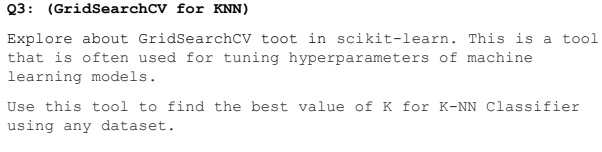

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
from sklearn.model_selection import GridSearchCV
params={'n_neighbors':[3,5,7,9,11],
        'weights':['uniform'],
        'metric':['euclidean','manhattan']}

In [ ]:
gs=GridSearchCV(knn,params,verbose=1,cv=3,n_jobs=-1)

In [ ]:
gs.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [ ]:
gs.best_score_

0.9464201043148411

In [ ]:
gs.best_params_

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}

In [ ]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')